In [1]:
import sqlite3
import random
import itertools
import subprocess
import os
import shlex
import time
import pickle

In [2]:
import bz2

In [110]:
from PIL import Image, ImageDraw, ImageFont

# from pillow import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [4]:
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model

Using TensorFlow backend.


In [5]:
# this seems to help with some GPU memory issues

import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [6]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)
print("model loaded")
model.summary()

W0725 16:11:14.384110 139713196320576 deprecation_wrapper.py:119] From /home/rte/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0725 16:11:14.384902 139713196320576 deprecation_wrapper.py:119] From /home/rte/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 16:11:14.401495 139713196320576 deprecation_wrapper.py:119] From /home/rte/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0725 16:11:14.420361 139713196320576 deprecation_wrapper.py:119] From /home/rte/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0725 16:11:15.522627 139713196

model loaded
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0       

In [13]:
def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [ ]:
# set up the feature extractor -- only needed if doing something with second last layer

feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
print("feature extractor setup")
feat_extractor.summary()

### Analyse samples and save csv

In [ ]:
current_path = "/home/rte/data/images/random/100k/classification/"
# current_path = convert_path

image_extensions = ['.jpg', '.png', '.jpeg']   # case-insensitive (upper/lower doesn't matter)
max_num_images = 100000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(current_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
num_x = len(images)
print("keeping %d images to analyze" % num_x)

In [ ]:
start = time.time()

all_predictions = []

features = []

writefile = "predictions_100k.txt"
f = open(writefile, "a+")
        
for i, image_path in enumerate(images):
    if i % 500 == 0:
        end = time.time()
        elap = end - start;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images),elap))
        start = time.time()
    img, x = load_image(image_path)
    
    f.write(os.path.basename(image_path))

#     feat = feat_extractor.predict(x)[0]
#     features.append(feat)
    
    predictions = model.predict(x)
    
#     print(predictions)
#     print(decode_predictions(predictions))
    
    for _, pred, prob in decode_predictions(predictions)[0]:
#         print("predicted %s with probability %0.3f" % (pred, prob))
        f.write("," + str(pred) + "," + str(prob))
                
    f.write("\n")
        
print('finished predicting class for %d images' % len(images))

f.close()

In [ ]:
# write images, predictions to a pickle file

f = "classification_vgg_subset" + ".pickle"

print(f)

# WRITE
with open(f, "wb") as write_file:
    pickle.dump([images, features], write_file)
    write_file.close()


### Decode predictions from pickle

In [ ]:
p = "/home/rte/re-imaging/visualisation/features/features_0_50000_vgg.pkl.pbz2"
predictions = []
with bz2.open(p, "r") as read_file:
    predictions = pickle.load(read_file)
for p in predictions[:5]:
    print(p)

In [ ]:
p = "/home/rte/re-imaging/visualisation/features/v1/features_0_50000_vgg.pkl.pbz2"
# predictions = []
with bz2.open(p, "r") as read_file:
    predictions = pickle.load(read_file)

writefile = "predictions_1m.txt"
f = open(writefile, "a+")

for pred in predictions[:1]:
    for _, pred, prob in decode_predictions(pred):
        print("predicted %s with probability %0.3f" % (pred, prob))
        f.write("," + str(pred) + "," + str(prob))

        f.write("\n")
        print('finished predicting class for %d images' % len(images))

f.close()

In [ ]:
len(predictions[0])

In [ ]:
image_folder = "/mnt/hd2/images/all/"
for i, image_path in enumerate(filepaths[:1]):
    img, x = load_image(image_folder + image_path)

    predictions = model.predict(x)
    print(predictions)

In [ ]:
len(predictions[0])

In [ ]:
print(predictions)

In [ ]:
predictions

In [ ]:
for _, pred, prob in decode_predictions(predictions)[0]:
        print("predicted %s with probability %0.3f" % (pred, prob))

In [ ]:
print(decode_predictions(predictions))

### Save predictions images

In [8]:
filepaths = []

with open("/home/rte/data/paths/all_converted_jpg_images_shuf.txt", "r") as f:
    lines = f.readlines()
    print("length:",len(lines))
    print(lines[0])
for l in lines:
    # substrings = l.rsplit(",", 1)
    filepaths.append(l.strip())
    # image_ids.append(substrings[1].strip())

length: 10052503
2971229.jpg



predictions/vgg16_prediction_slide_rule_91pc_2971229.jpg
predictions/vgg16_prediction_web_site_73pc_4795851.jpg
predictions/vgg16_prediction_rule_32pc_5288255.jpg
predictions/vgg16_prediction_crane_25pc_7981402.jpg
predictions/vgg16_prediction_rule_32pc_5620995.jpg
predictions/vgg16_prediction_envelope_19pc_5687230.jpg
predictions/vgg16_prediction_oscilloscope_29pc_4703638.jpg
predictions/vgg16_prediction_mouse_3pc_672051.jpg
predictions/vgg16_prediction_oscilloscope_98pc_3361961.jpg
predictions/vgg16_prediction_oscilloscope_29pc_7745015.jpg
predictions/vgg16_prediction_oscilloscope_72pc_6494464.jpg
predictions/vgg16_prediction_oscilloscope_39pc_601900.jpg
predictions/vgg16_prediction_crane_43pc_7487368.jpg
predictions/vgg16_prediction_menu_27pc_418472.jpg
predictions/vgg16_prediction_slide_rule_52pc_1113419.jpg
predictions/vgg16_prediction_crossword_puzzle_92pc_4274314.jpg
predictions/vgg16_prediction_maze_78pc_9099521.jpg
predictions/vgg16_prediction_web_site_35pc_6636581.jpg
predict

predictions/vgg16_prediction_nematode_37pc_9251599.jpg
predictions/vgg16_prediction_web_site_21pc_7595277.jpg
predictions/vgg16_prediction_coil_28pc_7257205.jpg
predictions/vgg16_prediction_web_site_26pc_2466755.jpg
predictions/vgg16_prediction_bow_14pc_8411485.jpg
predictions/vgg16_prediction_bow_29pc_3626498.jpg
predictions/vgg16_prediction_lighter_82pc_5348984.jpg
predictions/vgg16_prediction_slide_rule_90pc_7451237.jpg
predictions/vgg16_prediction_web_site_23pc_4705290.jpg
predictions/vgg16_prediction_swab_37pc_3189201.jpg
predictions/vgg16_prediction_oscilloscope_62pc_6863364.jpg
predictions/vgg16_prediction_scale_16pc_5191916.jpg
predictions/vgg16_prediction_bow_44pc_7957158.jpg
predictions/vgg16_prediction_spider_web_16pc_5481392.jpg
predictions/vgg16_prediction_web_site_37pc_1442782.jpg
predictions/vgg16_prediction_oscilloscope_40pc_4765079.jpg
predictions/vgg16_prediction_nematode_60pc_7425934.jpg
predictions/vgg16_prediction_binder_13pc_1724918.jpg
predictions/vgg16_predictio

predictions/vgg16_prediction_web_site_15pc_2962185.jpg
predictions/vgg16_prediction_envelope_19pc_9367893.jpg
predictions/vgg16_prediction_rule_66pc_6064310.jpg
predictions/vgg16_prediction_menu_30pc_8380780.jpg
predictions/vgg16_prediction_oscilloscope_22pc_6322280.jpg
predictions/vgg16_prediction_oscilloscope_76pc_1324416.jpg
predictions/vgg16_prediction_menu_8pc_194654.jpg
predictions/vgg16_prediction_slide_rule_56pc_598722.jpg
predictions/vgg16_prediction_slide_rule_75pc_8809909.jpg
predictions/vgg16_prediction_oscilloscope_71pc_6953218.jpg
predictions/vgg16_prediction_oscilloscope_84pc_8434238.jpg
predictions/vgg16_prediction_web_site_49pc_6717538.jpg
predictions/vgg16_prediction_rule_40pc_4705065.jpg
predictions/vgg16_prediction_slide_rule_41pc_4587501.jpg
predictions/vgg16_prediction_web_site_72pc_7370615.jpg
predictions/vgg16_prediction_abacus_44pc_7290361.jpg
predictions/vgg16_prediction_rule_41pc_5813850.jpg
predictions/vgg16_prediction_envelope_35pc_4587989.jpg
predictions/v

predictions/vgg16_prediction_slide_rule_41pc_2982470.jpg
predictions/vgg16_prediction_rule_58pc_2595301.jpg
predictions/vgg16_prediction_bow_50pc_1170463.jpg
predictions/vgg16_prediction_screwdriver_20pc_9737557.jpg
predictions/vgg16_prediction_mosquito_net_33pc_8475377.jpg
predictions/vgg16_prediction_crane_46pc_8627718.jpg
predictions/vgg16_prediction_maze_99pc_3395732.jpg
predictions/vgg16_prediction_crane_45pc_76350.jpg
predictions/vgg16_prediction_oscilloscope_44pc_2875190.jpg
predictions/vgg16_prediction_rule_24pc_8412536.jpg
predictions/vgg16_prediction_menu_75pc_5032576.jpg
predictions/vgg16_prediction_rule_24pc_8605373.jpg
predictions/vgg16_prediction_crossword_puzzle_39pc_559830.jpg
predictions/vgg16_prediction_rule_59pc_2878895.jpg
predictions/vgg16_prediction_cricket_22pc_7515075.jpg
predictions/vgg16_prediction_web_site_10pc_7680872.jpg
predictions/vgg16_prediction_oscilloscope_97pc_4972503.jpg
predictions/vgg16_prediction_envelope_26pc_9455857.jpg
predictions/vgg16_predic

predictions/vgg16_prediction_rule_15pc_2721360.jpg
predictions/vgg16_prediction_slide_rule_45pc_960572.jpg
predictions/vgg16_prediction_solar_dish_17pc_5356075.jpg
predictions/vgg16_prediction_menu_42pc_6888373.jpg
predictions/vgg16_prediction_swing_85pc_7955753.jpg
predictions/vgg16_prediction_jigsaw_puzzle_17pc_618112.jpg
predictions/vgg16_prediction_stupa_40pc_1100517.jpg
predictions/vgg16_prediction_oscilloscope_29pc_4842435.jpg
predictions/vgg16_prediction_crane_42pc_5362470.jpg
predictions/vgg16_prediction_web_site_40pc_6977943.jpg
predictions/vgg16_prediction_rule_46pc_5367380.jpg
predictions/vgg16_prediction_oscilloscope_46pc_6134269.jpg
predictions/vgg16_prediction_web_site_20pc_7360001.jpg
predictions/vgg16_prediction_menu_33pc_1687420.jpg
predictions/vgg16_prediction_diaper_59pc_5257403.jpg
predictions/vgg16_prediction_tripod_82pc_9917174.jpg
predictions/vgg16_prediction_suit_5pc_2850977.jpg
predictions/vgg16_prediction_web_site_55pc_6152120.jpg
predictions/vgg16_prediction_

predictions/vgg16_prediction_analog_clock_18pc_4280120.jpg
predictions/vgg16_prediction_fountain_pen_23pc_7397734.jpg
predictions/vgg16_prediction_jigsaw_puzzle_74pc_9987909.jpg
predictions/vgg16_prediction_maze_40pc_7509685.jpg
predictions/vgg16_prediction_stole_3pc_4954144.jpg
predictions/vgg16_prediction_jellyfish_99pc_9138291.jpg
predictions/vgg16_prediction_ski_25pc_2510639.jpg
predictions/vgg16_prediction_oscilloscope_29pc_5278387.jpg
predictions/vgg16_prediction_crane_25pc_1111035.jpg
predictions/vgg16_prediction_oscilloscope_92pc_8146083.jpg
predictions/vgg16_prediction_binder_17pc_9334253.jpg
predictions/vgg16_prediction_menu_53pc_1705053.jpg
predictions/vgg16_prediction_menu_16pc_3566799.jpg
predictions/vgg16_prediction_monitor_11pc_8500719.jpg
predictions/vgg16_prediction_oscilloscope_19pc_6784462.jpg
predictions/vgg16_prediction_stretcher_48pc_7720652.jpg
predictions/vgg16_prediction_ski_29pc_6357368.jpg
predictions/vgg16_prediction_oscilloscope_60pc_2611355.jpg
predictions

predictions/vgg16_prediction_slide_rule_51pc_1705907.jpg
predictions/vgg16_prediction_oscilloscope_31pc_3016902.jpg
predictions/vgg16_prediction_nematode_28pc_9777522.jpg
predictions/vgg16_prediction_oscilloscope_49pc_6124911.jpg
predictions/vgg16_prediction_shower_curtain_16pc_4953022.jpg
predictions/vgg16_prediction_crane_15pc_531421.jpg
predictions/vgg16_prediction_crossword_puzzle_51pc_3021712.jpg
predictions/vgg16_prediction_rule_58pc_8480495.jpg
predictions/vgg16_prediction_binder_46pc_10003013.jpg
predictions/vgg16_prediction_web_site_54pc_2514833.jpg
predictions/vgg16_prediction_oscilloscope_67pc_431580.jpg
predictions/vgg16_prediction_web_site_20pc_6994718.jpg
predictions/vgg16_prediction_analog_clock_55pc_5121493.jpg
predictions/vgg16_prediction_oscilloscope_35pc_2786526.jpg
predictions/vgg16_prediction_menu_9pc_5294861.jpg
predictions/vgg16_prediction_shower_curtain_17pc_3794221.jpg
predictions/vgg16_prediction_loupe_12pc_3011899.jpg
predictions/vgg16_prediction_envelope_29p

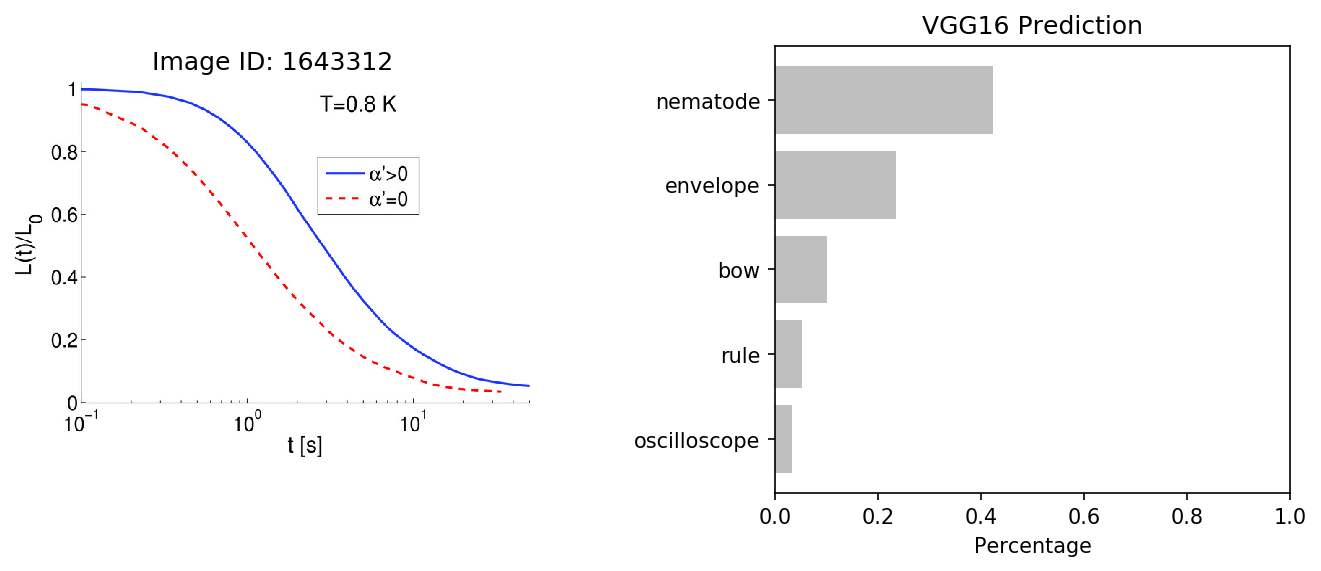

In [213]:
image_folder = "/mnt/hd2/images/all/"

plt.close('all')

for i, image_path in enumerate(filepaths[0:1000]):
    plt.close('all')

    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    fig.set_dpi(150)

    img, x = load_image(image_folder + image_path)
    im = mpimg.imread(image_folder + image_path)
#     pim = Image.open(image_folder + image_path)
    width, height = pim.size
#     print(width, height)
    asp = width/height
    
    prediction = model.predict(x)
    
    classes = []
    probabilities = []
    
    for i, (_, pred, prob) in enumerate(decode_predictions(prediction)[0]):
#         print("predicted %s with probability %0.3f" % (pred, prob))
        classes.append(pred)
        probabilities.append(prob)
        
    imgplot = ax[0].imshow(im, aspect=asp)
    ax[0].axis('off')
    ax[0].set_title("Image ID: " + image_path.split(".")[0])

    y_pos = np.arange(len(classes))

    my_cmap = cm.get_cmap('jet')
    my_norm = Normalize(vmin=0, vmax=8)
    
    probabilities = np.array(probabilities)
#     color = np.array(['rgb(255,255,255)']*probabilities.shape[0])
#     colors = cm.winter(probabilities)

    ax[1].set_xlim(0, 1)
    ax[1].barh(y_pos, probabilities, align='center', color='0.75')

#     ax[1].barh(y_pos, probabilities, align='center', color=my_cmap(my_norm(probabilities)))
    ax[1].set_yticks(y_pos)
    ax[1].set_yticklabels(classes)
    ax[1].invert_yaxis()
    ax[1].set_title('VGG16 Prediction')
    ax[1].set_xlabel('Percentage')
    
#     plt.subplots_adjust(wspace=0.5)
    plt.tight_layout(pad=5.0)

#     plt.axis('off')
#     target = "predictions/" + classes[0]
    target = "predictions"
#     print(target)
#     if not os.path.exists(target): os.mkdir(target)
        
    save_path = target + "/vgg16_prediction_" + classes[0] + "_" + \
                        "{:d}".format(int(probabilities[0]*100)) + "pc_" + \
                        image_path
    print(save_path)
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
# bbox_inches='tight'

In [20]:
import sys
image_folder = "/mnt/hd2/images/all/"

for i, image_path in enumerate(filepaths[0:1]):
#     if i % 500 == 0:
#         end = time.time()
#         elap = end - start;
#         print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images),elap))
#         start = time.time()
#     fig, ax = plt.subplots()
#     fig.set_size_inches(20, 10)

    img, x = load_image(image_folder + image_path)
    im = mpimg.imread(image_folder + image_path)
    width, height = pim.size
    print(width, height)
    asp = width/height
    
    pim = Image.open(image_folder + image_path)
    
#     out = Image.new('RGB', (720, 720), color = (200, 200, 200))
#     fnt = ImageFont.truetype("Pillow/Tests/fonts/FreeMono.ttf", 40)
#     d = ImageDraw.Draw(out)
    d = ImageDraw.Draw(pim)
    
#     out.show()
    pim.save(sys.stdout, "PNG")
    
    prediction = model.predict(x)
    
    classes = []
    probabilities = []
    
    for i, (_, pred, prob) in enumerate(decode_predictions(prediction)[0]):
#         print("predicted %s with probability %0.3f" % (pred, prob))
        classes.append(pred)
        probabilities.append(prob)
        
    for i, (c, p) in enumerate(zip(classes, probabilities)):
        y = i * 30 + 50
#         x = width 
        s = str(c) + " : "
#         plt.text(width + 100, y, s, horizontalalignment='right', fontsize=18)
#         plt.text(width + 170, y, "{:.2f} %".format(p*100), 
#                  horizontalalignment='right', fontsize=18)

520 512
�PNG

��1���4
DJ)@�������H��
h��1)%!�1�y�aAPJ�m�B��[��]��s)J��R�a�3MSB:���F��5��1,���a�� Jϟ��B��H�mۮ�3"� �4MJ)����)�9�5�9 B!�a��/��u�u]]ץ���0M�p]�0��%�R��麮�iaB  �!��-�!�1�v��}\M"A��P���M��	"9皦A�Uڟ7M+
J)!��<"�0������2? �jc�p�y���R+X�cR�0i�.�]����B�4s�����>�R�sN�À�:!D�a�Lj�P aF	!j��Ppα�B �,�P(�����x!��d2��0]#� 5d�QxP�6�!R�a�J����i�B�^}!C۶9��QJ5ʄe�=�t:�y���t�u-�*��������=�����@�ϗ@B �� 0�s\��v�3B=��u�K��|/�O|WH)�a��y!Ĳ,����$�!���c���,(�r�MӀR��n#��0,\��7���g�}֭G�|>�K���y�gY�m�Aئ�9/�� $!��=ιa�RS7
�B��o.�0�.]��dp��Ik�}���e	�A�����d=�+�� d�L�u]�ycCC�.]��l�u�m��0�8N:�nhh������:R
R�!����1�2��C H��9 F� 0M���������4��< �u��i�\
�y��R�B��� �4�0�-+����(�)x��r9<��R]ב�"��o/� � �mc{��۟7B�͹��0�4yj�V�`SJ�Q��i��aJ�`C�=�#����nUU#�u�R�
��ca���H)�٬e����,��4���z;��4�EP�&�R��RJ$�H�}��f�e������>a4�PpmS7M p�x�a(��u(�{*܍B�L&�<>
r��E�m�喷�z+�BH��x��+/g*�~)����o�OJ����/�h�×,�